意大利民防部门每天都会更新感染者的累积数据。这些数据在GitHub上作为开放数据公开在Github这里：

[https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv](https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv)

我的目标是创建迄今为止受感染人数（即实际感染人数加上已感染人数）的时间序列模型。这些模型具有参数，这些参数将通过曲线拟合进行估算。

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

## 数据收集（Data collection）

In [3]:
# 现在，让我们来看一下原始数据
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'

In [4]:
df = pd.read_csv(url)

In [6]:
df.shape

(48, 15)

In [7]:
df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,12,400,9587,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,17,650,12014,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,21,888,15695,NaN,NaN


In [8]:
df.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
43,2020-04-07T17:00:00,ITA,28718,3792,32510,61557,94067,880,3039,24392,17127,135586,755445,NaN,NaN
44,2020-04-08T17:00:00,ITA,28485,3693,32178,63084,95262,1195,3836,26491,17669,139422,807125,NaN,NaN
45,2020-04-09T17:00:00,ITA,28399,3605,32004,64873,96877,1615,4204,28470,18279,143626,853369,NaN,NaN
46,2020-04-10T17:00:00,ITA,28242,3497,31739,66534,98273,1396,3951,30455,18849,147577,906864,pd-IT-0011,pd-EN-0011
47,2020-04-11T17:00:00,ITA,28144,3381,31525,68744,100269,1996,4694,32534,19468,152271,963473,NaN,NaN


## 数据准备（Data preparation）

In [10]:
# 首先，我们需要将日期改成数字。
df = df.loc[:, ['data', 'totale_casi']]

In [13]:
FMT = '%Y-%m-%dT%H:%M:%S'
date = df['data']
df['data']= date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days)

### 现在，我们可以分析要参加测试的两个模型，分别是逻辑函数（logistic function）和指数函数（exponential function）。

### logistic模型（The logistic model）

logistic模型被广泛用于描述人口的增长。感染可以被描述为病原体数量的增长，因此使用logistic模型似乎是合理的。

这个公式在数据科学家中非常有名，因为它被用于逻辑回归分类器，并且是神经网络的一个激活函数。

logistic函数最一般的表达式为:
$$
f(x,a,b,c) = \frac{c}{1+e^{-(x-b)/a}}
$$
在这个公式中，我们有变量$x$（它是时间）和三个参数:$a,b,c$。

- a为感染速度
- b为感染发生最多的一天
- c是在感染结束时记录的感染者总数

在高时间值时，被感染的人数越来越接近c值，也就是我们说感染已经结束的时间点。这个函数在b点也有一个拐点，也就是一阶导数开始下降的点(即感染开始减弱并下降的峰值)。

In [16]:
# 定义模型
def logistic_model(x, a, b, c):
    return c/(1+np.exp(-(x-b)/a))

In [20]:
# 我们可以使用scipy库中的curve_fit函数从原始数据开始估计参数值和错误。
x = list(df.iloc[:,0])
x

[54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101]

In [21]:
y = list(df.iloc[:,1])
y

[229,
 322,
 400,
 650,
 888,
 1128,
 1694,
 2036,
 2502,
 3089,
 3858,
 4636,
 5883,
 7375,
 9172,
 10149,
 12462,
 15113,
 17660,
 21157,
 24747,
 27980,
 31506,
 35713,
 41035,
 47021,
 53578,
 59138,
 63927,
 69176,
 74386,
 80539,
 86498,
 92472,
 97689,
 101739,
 105792,
 110574,
 115242,
 119827,
 124632,
 128948,
 132547,
 135586,
 139422,
 143626,
 147577,
 152271]

In [22]:
fit = curve_fit(logistic_model, x, y, p0=[2, 100, 20000])

In [35]:
fit

(array([6.47926023e+00, 8.49714157e+01, 1.58438753e+05]),
 array([[1.83104817e-02, 2.34084901e-02, 2.10559286e+02],
        [2.34084901e-02, 5.09296122e-02, 3.99308983e+02],
        [2.10559286e+02, 3.99308983e+02, 3.63525092e+06]]))

In [36]:
a, b, c = fit[0]

In [37]:
a, b, c

(6.479260228506517, 84.97141573109829, 158438.75316505352)

In [29]:
# 该函数也返回协方差矩阵，其对角值是参数的方差。取它们的平方根，我们就能计算出标准误差。
errors = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]

In [31]:
errors

[0.1353162284597403, 0.22567590087444975, 1906.6333990077576]

这些数字给了我们许多有用的见解。

预计感染人数在感染结束时为15968+/-4174。

感染高峰预计在2020年3月9日左右。

预期的感染结束日期可以计算为受感染者累计计数四舍五入约等于到最接近整数的c参数的那一天。

我们可以使用scipy的fsolve函数来计算出定义感染结束日的方程的根。

In [38]:
sol =int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

In [39]:
sol

164

In [40]:
start_date = datetime.strptime("2020-01-01T00:00:00", FMT)

In [47]:
d1 = datetime(2008, 2, 16)
d2 = datetime(2009, 12, 31)

In [48]:
delta = d1 - d2

In [49]:
type(delta)

datetime.timedelta

In [51]:
from datetime import timedelta

In [52]:
delta2 = timedelta(days=sol)

In [54]:
end_date = start_date + delta2

In [55]:
end_date.strftime('%Y-%m-%d')

'2020-06-13'

## 指数模型（Exponential model）

logistic模型描述了未来将会停止的感染增长，而指数模型描述了不可阻挡的感染增长。例如，如果一个病人每天感染2个病人，1天后我们会有2个感染，2天后4个，3天后8个，等等。

最通用的指数函数是：
$$
f(x,a,b,c) = a \cdot e^{b(x-c)}
$$
变量x是时间，我们仍然有参数a, b, c，但是它的意义不同于logistic函数参数。

In [58]:
# 定义函数
def exponential_model(x, a, b, c):
    return a * np.exp(b * (x - c))

In [60]:
exp_fit = curve_fit(exponential_model, x, y, p0=[1, 1, 1],  maxfev=500000)

In [61]:
exp_fit

(array([ 37.02774443,   0.06188937, -35.91082343]),
 array([[2.12371912e+15, 2.73173703e+04, 9.26731171e+14],
        [2.73173904e+04, 1.07764506e-05, 1.19205611e+04],
        [9.26731171e+14, 1.19205523e+04, 4.04399364e+14]]))

In [62]:
a, b, c = exp_fit[0]

In [63]:
a, b, c

(37.027744431541265, 0.06188937206348219, -35.91082343240964)

In [64]:
errors = [np.sqrt(exp_fit[1][i][i]) for i in [0, 1, 2]]

In [70]:
errors

[46083827.14407333, 0.0032827504594552287, 20109683.338872105]

In [69]:
exp_sol =int(fsolve(lambda x : exponential_model(x,a,b,c) - int(c),b))

In [71]:
exp_sol

-575

In [74]:
pred_x= list(range(max(x),sol))
pred_x

[101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163]

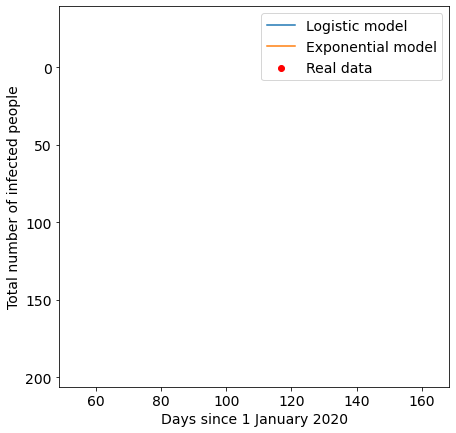

In [68]:
pred_x= list(range(max(x),sol))
plt.rcParams['figure.figsize']= [7, 7]
plt.rc('font',size=14)

## Realdata
plt.scatter(x,y,label="Real data",color="red")
#Predicted logistic curve
plt.plot(x+pred_x,[logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
#Predicted exponential curve
plt.plot(x+pred_x,[exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2])for i in x+pred_x], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()